Deep Learning for MSc Coursework 2022

Identify different types of cell nuclei in colon cancer

Import necessary libraries 

In [ ]:
from __future__ import division, print_function, unicode_literals
from google.colab import files

import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
import collections
import datetime

from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.utils as vutils
from torchvision.transforms import ToTensor
import torchvision.datasets as dset
import torchvision.transforms as transforms
import csv
from torchvision.transforms.transforms import RandomHorizontalFlip



%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Importing the Train Dataset by mounting the google drive 

In [ ]:
train_dataset = dset.ImageFolder(root='/content/drive/MyDrive/dataset/train/train',
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.RandomHorizontalFlip(), #Data Augmentation done to increase accuracy
                               transforms.RandomRotation(10), #Data Augmentation done to increase accuracy
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                         shuffle=True, num_workers=2) #Loading the training data in batches and shuffling through the set


Importing the Test Dataset from the mounted google drive

In [ ]:
test_dataset = dset.ImageFolder(root='/content/drive/MyDrive/dataset/test',
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
test_dataloader = torch.utils.data.DataLoader(test_dataset) # Using Dataloader to pull through the test data

Looking at the min and max values of the train data set to determine the activation function to be used in autoencoder

In [ ]:
dataiter= iter(train_dataloader)
images,labels = dataiter.next()
print(torch.min(images),torch.max(images))

tensor(-1.) tensor(1.)


Since the min and max values lie with the range of (-1,1) due to the normalisation with (0.5, 0.5, 0.5), using the tanh activation function in decoding the data would provide with test images.

Defining the classes(labels) of the cancer images. This class would be used in our predictions to determine the type of cancer

In [ ]:
classes=('Cancer','Connective','Immune','Normal')

Printing the train and test data set retrieved from the drive and the transforms made

In [ ]:
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 1700
    Root location: /content/drive/MyDrive/dataset/train/train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(32, 32))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset ImageFolder
    Number of datapoints: 3200
    Root location: /content/drive/MyDrive/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(32, 32))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Single batch view of the train data set. 

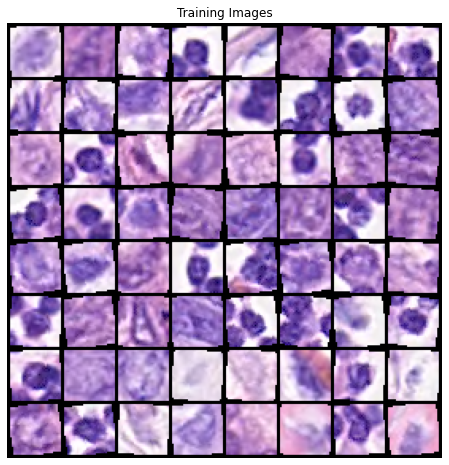

In [ ]:
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

It can be seen from the above diagram that some random images have been flipped and rotated according to the tranformations done on the train data set. This helps to generalise the model and avoid overfitting of the model to the train data

Creation of the CovNet Model

In [ ]:
model = nn.Sequential(collections.OrderedDict([
          #the first layer contains 3 input channels (RGB) and 15 output channels with the kernel of 3X3
          ('conv1', nn.Conv2d(3,15,3,padding=1)),
          ('relu1', nn.ReLU()),

          #Second layer contains the maxpool that reduces the output window
          ('mp1'  , nn.MaxPool2d(2)), # using max pool to avoid overfitting and downsize the input channels
          ('do1'  , nn.Dropout(p=0.2)), # using dropout to again generalise the model and avoid overfitting

          #third layer - input channel - 15 (output of the first layer) and the output layer - 32 with kernel 3X3
          ('conv2', nn.Conv2d(15,32,3,padding=1)),
          ('relu2', nn.ReLU()),
          ('do2'  , nn.Dropout(p=0.2)),

          #Fourth layer - input channel - 32 and output is 64 with kernel 3X3
          ('conv3', nn.Conv2d(32,64,3,padding=1)),
          ('relu3', nn.ReLU()),

          #Fifth layer - maxpool that reduces the output window further
          ('mp2'  , nn.MaxPool2d(2)),
          ('do3'  , nn.Dropout(p=0.2)),
          
          #Flattening the data
          ('flatten', nn.Flatten()),   

          #Sixth layer is the fully connected layer with input of 64X8X8 and output of 1028                                       
          ('fc1', nn.Linear(64*8*8,1028)),
          ('relu1', nn.ReLU()),

          #Seventh layer if another fully connected layer with input of 1028 and output of 4
          ('fc2', nn.Linear(1028,4)),
        ]))

During the creation of the covnet the initial input channel is 3 to represent the color channels (RGB) of the images and then modifying the output channels to create a proper covnet. Maxpool and dropout are used to avoid overfitting and generalise the model, so that it gives better accuracy with the unknown data.

Since `maxpool` has been used as two layers, the image is downsied to 8X8 from 32X32 and iot provides the maximum value from the input window. This helps to reduce the parameters that the model has to learn from and helps focus on the ones that provide information about the image

The `dropout` function helps to regularise the model but randomly zero-ing the data in traning set. This further helps the model to perform well with unknown data

Displaying the created CNN model

In [ ]:
print("\nCNN Network Model:")
print(model)


CNN Network Model:
Sequential(
  (conv1): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(15, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (do2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do3): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=4, bias=True)
)


Training Loop to train the model with the train data

The to(device) helps to check if the GPU is available and runs the model on GPU which inturn helps in parallel processing.

Essentially the `training_loop` function, trains the model on the training data set and returns the loss and accuracy associated with each epoch.

The best model with the least loss is chosen and the test dataset is run on that model.

In [ ]:
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    min_loss = 1.0 #setting min loss to 1.0

    #Iterating through epochs
    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        correct=0
        acc=0.0

        #iterating through the training data loader (batch size=128)
        for imgs, labels in train_loader:

            #calling the model on the training images
            outputs = model(imgs.to(device))

            #Calling the loss function with the results from the model and the truth labels from the training dataset
            loss = loss_fn(outputs, labels.to(device),)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

            #getting the prediction from the output and calculating if the labels match 
            pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

        #Calculating the loss and accuracy of the epoch
        loss_train /= len(train_loader.dataset)
        acc = 100. * correct / len(train_loader.dataset)

        #Saving the best model (epoch) with the lowest loss 
        if loss_train<min_loss:
          min_loss=loss_train
          PATH = '/content/drive/MyDrive/dataset/model.pth'
          torch.save(model.state_dict(), PATH)
          print('Epoch ',epoch,' saved')

        #Prining the epoch,loss and accuracy per epoch run    
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
            print('\nTest set: Average loss: {}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                float(loss_train), correct, len(train_loader.dataset), acc))

Defining the loss function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


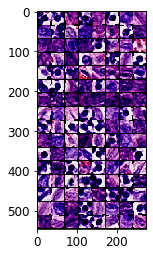

In [ ]:
#setting the learning rate to 0.005
lr = 0.005

#optimizer - Adam with the model parameters and the baove set lr
optimizer = optim.Adam(model.parameters(), lr=lr)

#Plotting the images of the first batch of the training data
images, labels = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

#loss function using Cross Entropy
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([3.4,3.4,3.4,8.5]))

The weights of the loss functions have been set in such a way that they can make up for the unbalanced data set. The training data set contains unequal amount of images for each category. the `normal` category has lesser number of images than the rest but the unknown test dataset may contain equally balanced data from al categories.

Hence it is mandatory to handle this inequality so that the model can be trained in such a way that it can categorise the images even when the training data is biased.

The weights have been calculated by taking into account the number of images for each category and dividing by total number of mages in the training data

Calling the `training_loop` to train the model with the optimizer, loss function and the epoch size

In [ ]:
#specifying the epoch size
n_epochs = 10

training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
)

Epoch  1  saved
2022-03-25 14:29:54.216326 Epoch 1, Training loss 0.019165088709662943

Test set: Average loss: 0.019165088709662943, Accuracy: 520/1700 (31%)

Epoch  2  saved
2022-03-25 14:29:59.699195 Epoch 2, Training loss 0.007388429466415854

Test set: Average loss: 0.007388429466415854, Accuracy: 1106/1700 (65%)

Epoch  3  saved
2022-03-25 14:30:05.313333 Epoch 3, Training loss 0.005205589199767394

Test set: Average loss: 0.005205589199767394, Accuracy: 1282/1700 (75%)

Epoch  4  saved
2022-03-25 14:30:10.807692 Epoch 4, Training loss 0.004016899291206809

Test set: Average loss: 0.004016899291206809, Accuracy: 1393/1700 (82%)

Epoch  5  saved
2022-03-25 14:30:16.402126 Epoch 5, Training loss 0.003520228056346669

Test set: Average loss: 0.003520228056346669, Accuracy: 1434/1700 (84%)

Epoch  6  saved
2022-03-25 14:30:22.127521 Epoch 6, Training loss 0.00277045859133496

Test set: Average loss: 0.00277045859133496, Accuracy: 1496/1700 (88%)

Epoch  7  saved
2022-03-25 14:30:27.6

The above run shows the accuracy and loss for each epoch and the best model that is being saved

Loading the best model that is saved to run the test data.

The model can be loaded by using the `load_state_dict` function

In [ ]:
PATH = '/content/drive/MyDrive/dataset/model.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Passing the test data to the trained model to capture the predictions

In [ ]:
#creating a prediction list to store the predictions from the model
pred=[]

#Iterating through test dataloader
for data, target in test_dataloader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred.append(output.argmax(dim=1, keepdim=True)) #Storing the max value from the output which essentially gives the index of the label

Checking the length of the predictions and displaying the predictions to see the labels

In [ ]:
print(len(pred))
print('Predicted: ', ' '.join(f'{classes[pred[j]]:5s}'for j in range(len(pred))))

3200
Predicted:  Connective Connective Connective Connective Connective Connective Connective Connective Connective Cancer Connective Connective Connective Connective Normal Cancer Cancer Connective Connective Connective Normal Cancer Connective Connective Connective Connective Cancer Cancer Cancer Connective Connective Connective Connective Connective Normal Cancer Connective Connective Connective Connective Cancer Connective Connective Cancer Connective Connective Connective Connective Connective Connective Cancer Cancer Connective Connective Connective Connective Connective Cancer Connective Connective Connective Immune Connective Connective Cancer Connective Cancer Connective Cancer Cancer Cancer Immune Cancer Connective Connective Connective Immune Cancer Connective Connective Connective Normal Cancer Connective Cancer Connective Connective Cancer Immune Connective Connective Connective Connective Cancer Connective Connective Connective Connective Connective Connective Immune Conn

**Storing the image with the predicted labels** 

The file to be submitted needs to have the image id(N.png) and the predicted label.

to get the image id- the `.imgs()` can be used that essentially provides the entire content taht is being stored in the data set. from this the title of the image can be obtained using the `split()`. 

To get the prediction labels- the `classes` which was initialised above with the labels of the cancer cell can be called using the predicted index.

In [ ]:
test_pred={}
for i in range(len(test_dataset)):
  test_pred[test_dataset.imgs[i][0].split('/')[-1]]=classes[pred[i]]
  

In [ ]:
#Creating a file to save the image id and the predictions
with open('/content/drive/MyDrive/dataset/predictions.csv', 'w') as f:
  f.write("%s,%s\n"%('Id','Type'))
  for key in test_pred.keys():
    f.write("%s,%s\n"%(key,test_pred[key]))

Autoencoder